In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os

In [2]:
simpson_img = pd.read_csv('../simpsons_dataset/simpson_img_list.csv')
print(simpson_img.head())

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg


<class 'numpy.ndarray'>


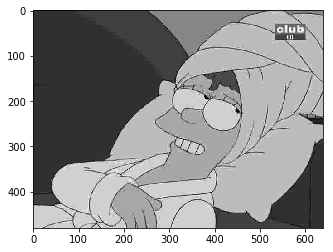

In [3]:
img = cv2.imread('../simpsons_dataset/' + simpson_img.img.iloc[0], 0)
print(type(img))
plt.imshow(img, cmap="gray")

In [4]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]  #只取名字含有simpson的類別

simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()#將label做 one_hot encoding

C:\Users\charles\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
x_train, y_train = simpson_img, simpson_y

img = cv2.resize(img, (50, 50))
img = img.flatten()
print('input_data shape: training {training_shape}'.format(
            training_shape=(len(x_train), img.shape[0])))
print('y_true shape: training {training_shape}'.format(
            training_shape=y_train.shape))

input_data shape: training (7274, 2500)
y_true shape: training (7274, 6)


In [6]:
from sklearn.utils import shuffle

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis = 0)
        for i in range(len(x)):
            dir_img = '../simpsons_dataset/' + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

In [7]:
tf.reset_default_graph()

In [8]:
# 建立placeholder
input_data = tf.placeholder(dtype = tf.float32, shape = [None, img.shape[0]], name = 'input_data')
y_true = tf.placeholder(dtype = tf.float32, shape = [None,  y_train.shape[1]], name = 'y_true')

In [9]:
# 建立dense層神經網路
x1 = tf.layers.dense(input_data, 512, activation = tf.nn.sigmoid, name='hidden1')
x2 = tf.layers.dense(x1, 256, activation = tf.nn.sigmoid, name = 'hidden2')
x3 = tf.layers.dense(x2, 128, activation = tf.nn.sigmoid, name = 'hidden3')
x4 = tf.layers.dense(x3, 64, activation = tf.nn.sigmoid, name = 'hidden4')
x5 = tf.layers.dense(x4, 32, activation = tf.nn.sigmoid, name = 'hidden5')
out = tf.layers.dense(x5, y_train.shape[1], name = 'output')
y_pred = out

In [10]:
#定義 Loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
#定義優化器
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)

update = opt.minimize(loss)

In [12]:
#檢查Variables
tf.global_variables()

[<tf.Variable 'hidden1/kernel:0' shape=(2500, 512) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden4/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'hidden5/kernel:0' shape=(64, 32) dtype=float32_ref>,
 <tf.Variable 'hidden5/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(32, 6) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(6,) dtype=float32_ref>]

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [15]:
from tqdm import tqdm #用來顯示進度條的套件
from sklearn.metrics import accuracy_score

epoch = 30 #epoch
bs = 32 #batch size
update_per_epoch = 100 #一個epoch要跑幾個batch

tr_loss = list() #存training過程中的loss值
tr_acc = list() #存training過程中的準確率
train_gen = simpson_train_batch_generator(x_train, y_train, bs, img.shape[0])

for i in range(epoch):
    training_loss = 0
    training_acc = 0
    bar = tqdm(range(update_per_epoch))
    
    for j in tqdm(range(update_per_epoch)):
        x_batch, y_batch = next(train_gen)
        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict = {
            input_data : x_batch,
            y_true : y_batch
        })
        training_loss += training_loss_batch
        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % training_loss_batch) #進度條
            
    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
    
    print('epoch {epochs}: training loss {training_loss}'.format(
            epochs = (i+1), 
            training_loss = training_loss))#每個epoch結束後顯示目前的的training loss

100%|██████████| 100/100 [00:03<00:00, 33.03it/s]


epoch 1: training loss 1.853298978805542



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


epoch 2: training loss 1.7958980643749236



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.13it/s]


epoch 3: training loss 1.751137727499008



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.44it/s]


epoch 4: training loss 1.7410312354564668



  0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.835:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.725:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.722:   0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:02, 31.51it/s]

loss: 1.648:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.736:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.748:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.681:   0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [00:00<00:02, 32.83it/s]

loss: 1.621:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.72:   0%|          | 0/100 [00:01<?, ?it/s] 

loss: 1.867:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.765:   0%|          | 0/100 [00:01<?, ?it/s]

 51%|█████     | 51/100 [00:01<00:01, 33.11it/s]

loss: 1.694:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.805:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.672:   0%|          | 0/100 [00:02<?, ?it/s]

loss: 1.607:   0%|          | 0/100 [00:02<?, ?it/s]

epoch 5: training loss 1.714409350156784




  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.672:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.701:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.784:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.623:   0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:02, 33.63it/s]

loss: 1.688:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.76:   0%|          | 0/100 [00:00<?, ?it/s] 

loss: 1.738:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.635:   0%|          | 0/100 [00:01<?, ?it/s]

 36%|███▌      | 36/100 [00:01<00:01, 33.47it/s]

loss: 1.694:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.633:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.696:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.73:   0%|          | 0/100 [00:01<?, ?it/s] 

 56%|█████▌    | 56/100 [00:01<00:01, 33.41it/s]

loss: 1.737:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.728:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.656:   0%|          | 0/100 [00:02<?, ?it/

epoch 6: training loss 1.6957942461967468




  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.688:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.722:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.742:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.722:   0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:02, 33.08it/s]

loss: 1.749:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.547:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.782:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.706:   0%|          | 0/100 [00:01<?, ?it/s]

 36%|███▌      | 36/100 [00:01<00:01, 32.84it/s]

loss: 1.679:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.51:   0%|          | 0/100 [00:01<?, ?it/s] 

loss: 1.682:   0%|          | 0/100 [00:01<?, ?it/s]

loss: 1.637:   0%|          | 0/100 [00:01<?, ?it/s]

 56%|█████▌    | 56/100 [00:01<00:01, 32.72it/s]

loss: 1.72:   0%|          | 0/100 [00:01<?, ?it/s] 

loss: 1.805:   0%|          | 0/100 [00:02<?, ?it/s]

loss: 1.655:   0%|          | 0/100 [00:02<?, ?it/

epoch 7: training loss 1.6840865921974182




  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.599:   0%|          | 0/100 [00:00<?, ?it/s]


  3%|▎         | 3/100 [00:00<00:03, 29.49it/s]

loss: 1.591:   0%|          | 0/100 [00:00<?, ?it/s]


  7%|▋         | 7/100 [00:00<00:03, 30.92it/s]

loss: 1.728:   0%|          | 0/100 [00:00<?, ?it/s]


 11%|█         | 11/100 [00:00<00:02, 31.69it/s]


 15%|█▌        | 15/100 [00:00<00:02, 31.93it/s]

loss: 1.675:   0%|          | 0/100 [00:00<?, ?it/s]


 19%|█▉        | 19/100 [00:00<00:02, 32.23it/s]

loss: 1.681:   0%|          | 0/100 [00:00<?, ?it/s]


 23%|██▎       | 23/100 [00:00<00:02, 32.07it/s]

loss: 1.638:   0%|          | 0/100 [00:00<?, ?it/s]


 27%|██▋       | 27/100 [00:00<00:02, 31.89it/s]

loss: 1.744:   0%|          | 0/100 [00:00<?, ?it/s]


 31%|███       | 31/100 [00:00<00:02, 32.14it/s]


 35%|███▌      | 35/100 [00:01<00:02, 32.23it/s]

loss: 1.636:   0%|          | 0/100 [00:01<?, ?it/s]


 39%|███▉      | 39/100 [

epoch 8: training loss 1.6765224432945252





  0%|          | 0/100 [00:00<?, ?it/s]




  0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.627:   0%|          | 0/100 [00:00<?, ?it/s]


  4%|▍         | 4/100 [00:00<00:02, 33.27it/s]

loss: 1.772:   0%|          | 0/100 [00:00<?, ?it/s]


  8%|▊         | 8/100 [00:00<00:02, 33.32it/s]

loss: 1.698:   0%|          | 0/100 [00:00<?, ?it/s]


 12%|█▏        | 12/100 [00:00<00:02, 32.80it/s]

loss: 1.821:   0%|          | 0/100 [00:00<?, ?it/s]


 16%|█▌        | 16/100 [00:00<00:02, 32.69it/s]


 20%|██        | 20/100 [00:00<00:02, 32.62it/s]

loss: 1.691:   0%|          | 0/100 [00:00<?, ?it/s]


 24%|██▍       | 24/100 [00:00<00:02, 32.84it/s]

loss: 1.729:   0%|          | 0/100 [00:00<?, ?it/s]


 28%|██▊       | 28/100 [00:00<00:02, 32.92it/s]

loss: 1.584:   0%|          | 0/100 [00:00<?, ?it/s]


 32%|███▏      | 32/100 [00:00<00:02, 32.92it/s]

loss: 1.639:   0%|          | 0/100 [00:01<?, ?it/s]


 36%|███▌      | 36/100 [00:01<00:01, 33.00it/s]


 40%|████      | 40/10

epoch 9: training loss 1.6716844367980956





  0%|          | 0/100 [00:00<?, ?it/s]




  0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.603:   0%|          | 0/100 [00:00<?, ?it/s]


  4%|▍         | 4/100 [00:00<00:02, 32.78it/s]

loss: 1.504:   0%|          | 0/100 [00:00<?, ?it/s]


  8%|▊         | 8/100 [00:00<00:02, 32.49it/s]

loss: 1.567:   0%|          | 0/100 [00:00<?, ?it/s]


 12%|█▏        | 12/100 [00:00<00:02, 32.17it/s]

loss: 1.661:   0%|          | 0/100 [00:00<?, ?it/s]


 16%|█▌        | 16/100 [00:00<00:02, 32.67it/s]


 20%|██        | 20/100 [00:00<00:02, 33.09it/s]

loss: 1.676:   0%|          | 0/100 [00:00<?, ?it/s]


 24%|██▍       | 24/100 [00:00<00:02, 33.14it/s]

loss: 1.746:   0%|          | 0/100 [00:00<?, ?it/s]


 28%|██▊       | 28/100 [00:00<00:02, 32.91it/s]

loss: 1.694:   0%|          | 0/100 [00:00<?, ?it/s]


 32%|███▏      | 32/100 [00:00<00:02, 32.77it/s]

loss: 1.685:   0%|          | 0/100 [00:01<?, ?it/s]


 36%|███▌      | 36/100 [00:01<00:01, 32.55it/s]


 40%|████      | 40/10

epoch 10: training loss 1.6580404353141784





  0%|          | 0/100 [00:00<?, ?it/s]



  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.725:   0%|          | 0/100 [00:00<?, ?it/s]



  4%|▍         | 4/100 [00:00<00:03, 31.80it/s]


loss: 1.616:   0%|          | 0/100 [00:00<?, ?it/s]



  8%|▊         | 8/100 [00:00<00:02, 32.20it/s]


loss: 1.644:   0%|          | 0/100 [00:00<?, ?it/s]



 12%|█▏        | 12/100 [00:00<00:02, 32.33it/s]


loss: 1.747:   0%|          | 0/100 [00:00<?, ?it/s]



 16%|█▌        | 16/100 [00:00<00:02, 32.60it/s]



 20%|██        | 20/100 [00:00<00:02, 32.39it/s]


loss: 1.678:   0%|          | 0/100 [00:00<?, ?it/s]



 23%|██▎       | 23/100 [00:00<00:02, 31.85it/s]


loss: 1.75:   0%|          | 0/100 [00:00<?, ?it/s] 



 27%|██▋       | 27/100 [00:00<00:02, 31.73it/s]


loss: 1.613:   0%|          | 0/100 [00:00<?, ?it/s]



 31%|███       | 31/100 [00:00<00:02, 32.01it/s]



 35%|███▌      | 35/100 [00:01<00:02, 32.10it/s]


loss: 1.669:   0%|          | 0/100 [00:01<?, ?it/s]



 39%|

epoch 11: training loss 1.6561732530593871






  0%|          | 0/100 [00:00<?, ?it/s]






  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.755:   0%|          | 0/100 [00:00<?, ?it/s]



  4%|▍         | 4/100 [00:00<00:02, 33.70it/s]


loss: 1.712:   0%|          | 0/100 [00:00<?, ?it/s]



  8%|▊         | 8/100 [00:00<00:02, 32.80it/s]


loss: 1.749:   0%|          | 0/100 [00:00<?, ?it/s]



 12%|█▏        | 12/100 [00:00<00:02, 32.56it/s]


loss: 1.744:   0%|          | 0/100 [00:00<?, ?it/s]



 16%|█▌        | 16/100 [00:00<00:02, 32.77it/s]



 20%|██        | 20/100 [00:00<00:02, 33.01it/s]


loss: 1.759:   0%|          | 0/100 [00:00<?, ?it/s]



 24%|██▍       | 24/100 [00:00<00:02, 32.94it/s]


loss: 1.668:   0%|          | 0/100 [00:00<?, ?it/s]



 28%|██▊       | 28/100 [00:00<00:02, 33.05it/s]


loss: 1.632:   0%|          | 0/100 [00:00<?, ?it/s]



 32%|███▏      | 32/100 [00:00<00:02, 32.98it/s]


loss: 1.749:   0%|          | 0/100 [00:01<?, ?it/s]



 36%|███▌      | 36/100 [00:01<00:01, 32.97it/s]



 

epoch 12: training loss 1.6594183492660521






  0%|          | 0/100 [00:00<?, ?it/s]






  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.601:   0%|          | 0/100 [00:00<?, ?it/s]



  4%|▍         | 4/100 [00:00<00:02, 33.42it/s]


loss: 1.769:   0%|          | 0/100 [00:00<?, ?it/s]



  8%|▊         | 8/100 [00:00<00:02, 33.01it/s]


loss: 1.658:   0%|          | 0/100 [00:00<?, ?it/s]



 12%|█▏        | 12/100 [00:00<00:02, 33.42it/s]


loss: 1.615:   0%|          | 0/100 [00:00<?, ?it/s]



 16%|█▌        | 16/100 [00:00<00:02, 33.15it/s]



 20%|██        | 20/100 [00:00<00:02, 32.93it/s]


loss: 1.604:   0%|          | 0/100 [00:00<?, ?it/s]



 24%|██▍       | 24/100 [00:00<00:02, 32.83it/s]


loss: 1.681:   0%|          | 0/100 [00:00<?, ?it/s]



 28%|██▊       | 28/100 [00:00<00:02, 32.80it/s]


loss: 1.674:   0%|          | 0/100 [00:00<?, ?it/s]



 32%|███▏      | 32/100 [00:00<00:02, 32.47it/s]


loss: 1.675:   0%|          | 0/100 [00:01<?, ?it/s]



 36%|███▌      | 36/100 [00:01<00:01, 32.54it/s]



 

epoch 13: training loss 1.6495095121860504






  0%|          | 0/100 [00:00<?, ?it/s]






  0%|          | 0/100 [00:00<?, ?it/s]


loss: 1.639:   0%|          | 0/100 [00:00<?, ?it/s]



  4%|▍         | 4/100 [00:00<00:02, 33.99it/s]


loss: 1.614:   0%|          | 0/100 [00:00<?, ?it/s]



  8%|▊         | 8/100 [00:00<00:02, 33.99it/s]


loss: 1.667:   0%|          | 0/100 [00:00<?, ?it/s]



 12%|█▏        | 12/100 [00:00<00:02, 33.70it/s]


loss: 1.571:   0%|          | 0/100 [00:00<?, ?it/s]



 16%|█▌        | 16/100 [00:00<00:02, 32.87it/s]



 20%|██        | 20/100 [00:00<00:02, 32.50it/s]


loss: 1.653:   0%|          | 0/100 [00:00<?, ?it/s]



 24%|██▍       | 24/100 [00:00<00:02, 32.48it/s]


loss: 1.845:   0%|          | 0/100 [00:00<?, ?it/s]



 28%|██▊       | 28/100 [00:00<00:02, 32.57it/s]


loss: 1.668:   0%|          | 0/100 [00:00<?, ?it/s]



 32%|███▏      | 32/100 [00:00<00:02, 32.66it/s]


loss: 1.646:   0%|          | 0/100 [00:01<?, ?it/s]



 36%|███▌      | 36/100 [00:01<00:01, 32.62it/s]



 

epoch 14: training loss 1.6493248212337495






  0%|          | 0/100 [00:00<?, ?it/s]




  0%|          | 0/100 [00:00<?, ?it/s]



loss: 1.664:   0%|          | 0/100 [00:00<?, ?it/s]




  4%|▍         | 4/100 [00:00<00:02, 33.14it/s]



loss: 1.651:   0%|          | 0/100 [00:00<?, ?it/s]




  8%|▊         | 8/100 [00:00<00:02, 34.13it/s]



loss: 1.693:   0%|          | 0/100 [00:00<?, ?it/s]




 12%|█▏        | 12/100 [00:00<00:02, 33.99it/s]



loss: 1.638:   0%|          | 0/100 [00:00<?, ?it/s]




 16%|█▌        | 16/100 [00:00<00:02, 33.77it/s]




 20%|██        | 20/100 [00:00<00:02, 33.53it/s]



loss: 1.57:   0%|          | 0/100 [00:00<?, ?it/s] 




 24%|██▍       | 24/100 [00:00<00:02, 33.47it/s]



loss: 1.628:   0%|          | 0/100 [00:00<?, ?it/s]




 28%|██▊       | 28/100 [00:00<00:02, 33.48it/s]



loss: 1.744:   0%|          | 0/100 [00:00<?, ?it/s]




 32%|███▏      | 32/100 [00:00<00:02, 33.51it/s]



loss: 1.612:   0%|          | 0/100 [00:01<?, ?it/s]




 36%|███▌      | 36/100 [00:01<00:01, 

epoch 15: training loss 1.6415301656723023







  0%|          | 0/100 [00:00<?, ?it/s]








  0%|          | 0/100 [00:00<?, ?it/s]



loss: 1.583:   0%|          | 0/100 [00:00<?, ?it/s]




  4%|▍         | 4/100 [00:00<00:02, 32.72it/s]



loss: 1.675:   0%|          | 0/100 [00:00<?, ?it/s]




  8%|▊         | 8/100 [00:00<00:02, 32.66it/s]



loss: 1.563:   0%|          | 0/100 [00:00<?, ?it/s]




 12%|█▏        | 12/100 [00:00<00:02, 32.75it/s]



loss: 1.705:   0%|          | 0/100 [00:00<?, ?it/s]




 16%|█▌        | 16/100 [00:00<00:02, 32.52it/s]




 20%|██        | 20/100 [00:00<00:02, 32.90it/s]



loss: 1.648:   0%|          | 0/100 [00:00<?, ?it/s]




 24%|██▍       | 24/100 [00:00<00:02, 33.14it/s]



loss: 1.72:   0%|          | 0/100 [00:00<?, ?it/s] 




 28%|██▊       | 28/100 [00:00<00:02, 33.34it/s]



loss: 1.671:   0%|          | 0/100 [00:00<?, ?it/s]




 32%|███▏      | 32/100 [00:00<00:02, 33.44it/s]



loss: 1.722:   0%|          | 0/100 [00:01<?, ?it/s]




 36%|███▌      | 36/100 [00:01<00

epoch 16: training loss 1.6468279409408568







  0%|          | 0/100 [00:00<?, ?it/s]








  0%|          | 0/100 [00:00<?, ?it/s]



loss: 1.674:   0%|          | 0/100 [00:00<?, ?it/s]




  4%|▍         | 4/100 [00:00<00:02, 32.60it/s]



loss: 1.582:   0%|          | 0/100 [00:00<?, ?it/s]




  8%|▊         | 8/100 [00:00<00:02, 32.47it/s]



loss: 1.594:   0%|          | 0/100 [00:00<?, ?it/s]




 12%|█▏        | 12/100 [00:00<00:02, 32.87it/s]



loss: 1.556:   0%|          | 0/100 [00:00<?, ?it/s]




 16%|█▌        | 16/100 [00:00<00:02, 32.60it/s]




 20%|██        | 20/100 [00:00<00:02, 32.62it/s]



loss: 1.726:   0%|          | 0/100 [00:00<?, ?it/s]




 24%|██▍       | 24/100 [00:00<00:02, 32.49it/s]



loss: 1.549:   0%|          | 0/100 [00:00<?, ?it/s]




 28%|██▊       | 28/100 [00:00<00:02, 32.54it/s]



loss: 1.739:   0%|          | 0/100 [00:00<?, ?it/s]




 32%|███▏      | 32/100 [00:00<00:02, 32.68it/s]



loss: 1.76:   0%|          | 0/100 [00:01<?, ?it/s] 




 36%|███▌      | 36/100 [00:01<00

epoch 17: training loss 1.6481385147571563







  0%|          | 0/100 [00:00<?, ?it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




loss: 1.644:   0%|          | 0/100 [00:00<?, ?it/s]





  4%|▍         | 4/100 [00:00<00:03, 30.62it/s]




loss: 1.553:   0%|          | 0/100 [00:00<?, ?it/s]





  8%|▊         | 8/100 [00:00<00:02, 32.21it/s]




loss: 1.677:   0%|          | 0/100 [00:00<?, ?it/s]





 12%|█▏        | 12/100 [00:00<00:02, 32.31it/s]




loss: 1.681:   0%|          | 0/100 [00:00<?, ?it/s]





 16%|█▌        | 16/100 [00:00<00:02, 32.78it/s]





 20%|██        | 20/100 [00:00<00:02, 33.07it/s]




loss: 1.683:   0%|          | 0/100 [00:00<?, ?it/s]





 24%|██▍       | 24/100 [00:00<00:02, 33.04it/s]




loss: 1.577:   0%|          | 0/100 [00:00<?, ?it/s]





 28%|██▊       | 28/100 [00:00<00:02, 32.90it/s]




loss: 1.619:   0%|          | 0/100 [00:00<?, ?it/s]





 32%|███▏      | 32/100 [00:00<00:02, 32.96it/s]




loss: 1.632:   0%|          | 0/100 [00:01<?, ?it/s]





 36%|███▌      | 36

epoch 18: training loss 1.6414780390262604








  0%|          | 0/100 [00:00<?, ?it/s]










  0%|          | 0/100 [00:00<?, ?it/s]




loss: 1.666:   0%|          | 0/100 [00:00<?, ?it/s]





  4%|▍         | 4/100 [00:00<00:03, 31.51it/s]




loss: 1.627:   0%|          | 0/100 [00:00<?, ?it/s]





  8%|▊         | 8/100 [00:00<00:02, 31.75it/s]




loss: 1.604:   0%|          | 0/100 [00:00<?, ?it/s]





 12%|█▏        | 12/100 [00:00<00:02, 32.10it/s]




loss: 1.689:   0%|          | 0/100 [00:00<?, ?it/s]





 16%|█▌        | 16/100 [00:00<00:02, 32.42it/s]





 20%|██        | 20/100 [00:00<00:02, 32.72it/s]




loss: 1.774:   0%|          | 0/100 [00:00<?, ?it/s]





 24%|██▍       | 24/100 [00:00<00:02, 32.97it/s]




loss: 1.541:   0%|          | 0/100 [00:00<?, ?it/s]





 28%|██▊       | 28/100 [00:00<00:02, 32.99it/s]




loss: 1.628:   0%|          | 0/100 [00:00<?, ?it/s]





 32%|███▏      | 32/100 [00:00<00:02, 33.17it/s]




loss: 1.567:   0%|          | 0/100 [00:01<?, ?it/s]





 36%|███▌    

epoch 19: training loss 1.6413990330696107








  0%|          | 0/100 [00:00<?, ?it/s]










  0%|          | 0/100 [00:00<?, ?it/s]




loss: 1.61:   0%|          | 0/100 [00:00<?, ?it/s]





  4%|▍         | 4/100 [00:00<00:03, 31.18it/s]




loss: 1.625:   0%|          | 0/100 [00:00<?, ?it/s]





  8%|▊         | 8/100 [00:00<00:02, 31.88it/s]




loss: 1.728:   0%|          | 0/100 [00:00<?, ?it/s]





 12%|█▏        | 12/100 [00:00<00:02, 32.64it/s]




loss: 1.608:   0%|          | 0/100 [00:00<?, ?it/s]





 16%|█▌        | 16/100 [00:00<00:02, 32.90it/s]





 20%|██        | 20/100 [00:00<00:02, 32.84it/s]




loss: 1.578:   0%|          | 0/100 [00:00<?, ?it/s]





 24%|██▍       | 24/100 [00:00<00:02, 32.94it/s]




loss: 1.611:   0%|          | 0/100 [00:00<?, ?it/s]





 28%|██▊       | 28/100 [00:00<00:02, 32.97it/s]




loss: 1.724:   0%|          | 0/100 [00:00<?, ?it/s]





 32%|███▏      | 32/100 [00:00<00:02, 33.12it/s]




loss: 1.659:   0%|          | 0/100 [00:01<?, ?it/s]





 36%|███▌     

epoch 20: training loss 1.637826830148697








  0%|          | 0/100 [00:00<?, ?it/s]






  0%|          | 0/100 [00:00<?, ?it/s]





loss: 1.625:   0%|          | 0/100 [00:00<?, ?it/s]






  4%|▍         | 4/100 [00:00<00:02, 32.60it/s]





loss: 1.681:   0%|          | 0/100 [00:00<?, ?it/s]






  8%|▊         | 8/100 [00:00<00:02, 32.48it/s]





loss: 1.601:   0%|          | 0/100 [00:00<?, ?it/s]






 12%|█▏        | 12/100 [00:00<00:02, 32.78it/s]





loss: 1.552:   0%|          | 0/100 [00:00<?, ?it/s]






 16%|█▌        | 16/100 [00:00<00:02, 32.50it/s]






 20%|██        | 20/100 [00:00<00:02, 32.42it/s]





loss: 1.678:   0%|          | 0/100 [00:00<?, ?it/s]






 24%|██▍       | 24/100 [00:00<00:02, 32.58it/s]





loss: 1.596:   0%|          | 0/100 [00:00<?, ?it/s]






 28%|██▊       | 28/100 [00:00<00:02, 32.64it/s]





loss: 1.65:   0%|          | 0/100 [00:00<?, ?it/s] 






 32%|███▏      | 32/100 [00:00<00:02, 32.54it/s]





loss: 1.531:   0%|          | 0/100 [00:01<?, ?it/s]








epoch 21: training loss 1.629584766626358









  0%|          | 0/100 [00:00<?, ?it/s]












  0%|          | 0/100 [00:00<?, ?it/s]





loss: 1.674:   0%|          | 0/100 [00:00<?, ?it/s]






  4%|▍         | 4/100 [00:00<00:02, 33.15it/s]





loss: 1.593:   0%|          | 0/100 [00:00<?, ?it/s]






  8%|▊         | 8/100 [00:00<00:02, 33.85it/s]





loss: 1.56:   0%|          | 0/100 [00:00<?, ?it/s] 






 12%|█▏        | 12/100 [00:00<00:02, 33.99it/s]





loss: 1.691:   0%|          | 0/100 [00:00<?, ?it/s]






 16%|█▌        | 16/100 [00:00<00:02, 33.77it/s]






 20%|██        | 20/100 [00:00<00:02, 33.67it/s]





loss: 1.585:   0%|          | 0/100 [00:00<?, ?it/s]






 24%|██▍       | 24/100 [00:00<00:02, 33.66it/s]





loss: 1.54:   0%|          | 0/100 [00:00<?, ?it/s] 






 28%|██▊       | 28/100 [00:00<00:02, 33.67it/s]





loss: 1.64:   0%|          | 0/100 [00:00<?, ?it/s]






 32%|███▏      | 32/100 [00:00<00:02, 33.64it/s]





loss: 1.578:   0%|          | 0/100 [00:01<?, ?it/s]


epoch 22: training loss 1.6390170431137085









  0%|          | 0/100 [00:00<?, ?it/s]












  0%|          | 0/100 [00:00<?, ?it/s]





loss: 1.64:   0%|          | 0/100 [00:00<?, ?it/s]






  4%|▍         | 4/100 [00:00<00:02, 33.41it/s]





loss: 1.64:   0%|          | 0/100 [00:00<?, ?it/s]






  8%|▊         | 8/100 [00:00<00:02, 31.95it/s]





loss: 1.632:   0%|          | 0/100 [00:00<?, ?it/s]






 12%|█▏        | 12/100 [00:00<00:02, 32.34it/s]





loss: 1.705:   0%|          | 0/100 [00:00<?, ?it/s]






 16%|█▌        | 16/100 [00:00<00:02, 32.81it/s]






 20%|██        | 20/100 [00:00<00:02, 32.96it/s]





loss: 1.713:   0%|          | 0/100 [00:00<?, ?it/s]






 24%|██▍       | 24/100 [00:00<00:02, 32.77it/s]





loss: 1.576:   0%|          | 0/100 [00:00<?, ?it/s]






 27%|██▋       | 27/100 [00:00<00:02, 32.33it/s]





loss: 1.655:   0%|          | 0/100 [00:00<?, ?it/s]






 31%|███       | 31/100 [00:00<00:02, 32.50it/s]






 35%|███▌      | 35/100 [00:01<00:01, 32.57it/s]






epoch 23: training loss 1.637444167137146









  0%|          | 0/100 [00:00<?, ?it/s]







  0%|          | 0/100 [00:00<?, ?it/s]






loss: 1.617:   0%|          | 0/100 [00:00<?, ?it/s]







  4%|▍         | 4/100 [00:00<00:02, 32.34it/s]






loss: 1.666:   0%|          | 0/100 [00:00<?, ?it/s]







  8%|▊         | 8/100 [00:00<00:02, 33.01it/s]






loss: 1.584:   0%|          | 0/100 [00:00<?, ?it/s]







 12%|█▏        | 12/100 [00:00<00:02, 33.14it/s]






loss: 1.651:   0%|          | 0/100 [00:00<?, ?it/s]







 16%|█▌        | 16/100 [00:00<00:02, 33.28it/s]







 20%|██        | 20/100 [00:00<00:02, 33.37it/s]






loss: 1.65:   0%|          | 0/100 [00:00<?, ?it/s] 







 24%|██▍       | 24/100 [00:00<00:02, 33.47it/s]






loss: 1.563:   0%|          | 0/100 [00:00<?, ?it/s]







 28%|██▊       | 28/100 [00:00<00:02, 33.42it/s]






loss: 1.648:   0%|          | 0/100 [00:00<?, ?it/s]







 32%|███▏      | 32/100 [00:00<00:02, 33.53it/s]






loss: 1.734:   0%|          | 0/100 [00:0

epoch 24: training loss 1.6359341549873352










  0%|          | 0/100 [00:00<?, ?it/s]














  0%|          | 0/100 [00:00<?, ?it/s]






loss: 1.59:   0%|          | 0/100 [00:00<?, ?it/s]







  4%|▍         | 4/100 [00:00<00:02, 33.99it/s]






loss: 1.563:   0%|          | 0/100 [00:00<?, ?it/s]







  8%|▊         | 8/100 [00:00<00:02, 33.44it/s]






loss: 1.68:   0%|          | 0/100 [00:00<?, ?it/s] 







 12%|█▏        | 12/100 [00:00<00:02, 33.12it/s]






loss: 1.616:   0%|          | 0/100 [00:00<?, ?it/s]







 16%|█▌        | 16/100 [00:00<00:02, 32.89it/s]







 20%|██        | 20/100 [00:00<00:02, 33.10it/s]






loss: 1.682:   0%|          | 0/100 [00:00<?, ?it/s]







 24%|██▍       | 24/100 [00:00<00:02, 33.34it/s]






loss: 1.628:   0%|          | 0/100 [00:00<?, ?it/s]







 28%|██▊       | 28/100 [00:00<00:02, 33.00it/s]






loss: 1.626:   0%|          | 0/100 [00:00<?, ?it/s]







 32%|███▏      | 32/100 [00:00<00:02, 33.15it/s]






loss: 1.737:   0%|          | 0/10

epoch 25: training loss 1.6319789361953736










  0%|          | 0/100 [00:00<?, ?it/s]














  0%|          | 0/100 [00:00<?, ?it/s]






loss: 1.508:   0%|          | 0/100 [00:00<?, ?it/s]







  4%|▍         | 4/100 [00:00<00:02, 32.48it/s]






loss: 1.65:   0%|          | 0/100 [00:00<?, ?it/s] 







  8%|▊         | 8/100 [00:00<00:02, 32.86it/s]






loss: 1.662:   0%|          | 0/100 [00:00<?, ?it/s]







 12%|█▏        | 12/100 [00:00<00:02, 32.90it/s]






loss: 1.623:   0%|          | 0/100 [00:00<?, ?it/s]







 16%|█▌        | 16/100 [00:00<00:02, 33.19it/s]







 20%|██        | 20/100 [00:00<00:02, 33.34it/s]






loss: 1.606:   0%|          | 0/100 [00:00<?, ?it/s]







 24%|██▍       | 24/100 [00:00<00:02, 33.40it/s]






loss: 1.667:   0%|          | 0/100 [00:00<?, ?it/s]







 28%|██▊       | 28/100 [00:00<00:02, 33.33it/s]






loss: 1.739:   0%|          | 0/100 [00:00<?, ?it/s]







 32%|███▏      | 32/100 [00:00<00:02, 33.48it/s]






loss: 1.709:   0%|          | 0/1

epoch 26: training loss 1.6412304031848908










  0%|          | 0/100 [00:00<?, ?it/s]














  0%|          | 0/100 [00:00<?, ?it/s]






loss: 1.711:   0%|          | 0/100 [00:00<?, ?it/s]







  4%|▍         | 4/100 [00:00<00:02, 33.70it/s]






loss: 1.532:   0%|          | 0/100 [00:00<?, ?it/s]







  8%|▊         | 8/100 [00:00<00:02, 32.07it/s]






loss: 1.629:   0%|          | 0/100 [00:00<?, ?it/s]







 12%|█▏        | 12/100 [00:00<00:02, 31.81it/s]






loss: 1.608:   0%|          | 0/100 [00:00<?, ?it/s]







 16%|█▌        | 16/100 [00:00<00:02, 31.85it/s]







 20%|██        | 20/100 [00:00<00:02, 32.15it/s]






loss: 1.814:   0%|          | 0/100 [00:00<?, ?it/s]







 24%|██▍       | 24/100 [00:00<00:02, 32.27it/s]






loss: 1.601:   0%|          | 0/100 [00:00<?, ?it/s]







 28%|██▊       | 28/100 [00:00<00:02, 32.36it/s]






loss: 1.614:   0%|          | 0/100 [00:00<?, ?it/s]







 32%|███▏      | 32/100 [00:00<00:02, 32.19it/s]






loss: 1.637:   0%|          | 0/1

epoch 27: training loss 1.6225745832920075










  0%|          | 0/100 [00:00<?, ?it/s]








  0%|          | 0/100 [00:00<?, ?it/s]







loss: 1.62:   0%|          | 0/100 [00:00<?, ?it/s]








  4%|▍         | 4/100 [00:00<00:02, 32.40it/s]







loss: 1.627:   0%|          | 0/100 [00:00<?, ?it/s]








  8%|▊         | 8/100 [00:00<00:02, 32.63it/s]







loss: 1.621:   0%|          | 0/100 [00:00<?, ?it/s]








 12%|█▏        | 12/100 [00:00<00:02, 32.36it/s]







loss: 1.606:   0%|          | 0/100 [00:00<?, ?it/s]








 16%|█▌        | 16/100 [00:00<00:02, 32.29it/s]








 20%|██        | 20/100 [00:00<00:02, 32.51it/s]







loss: 1.508:   0%|          | 0/100 [00:00<?, ?it/s]








 24%|██▍       | 24/100 [00:00<00:02, 32.40it/s]







loss: 1.636:   0%|          | 0/100 [00:00<?, ?it/s]








 28%|██▊       | 28/100 [00:00<00:02, 32.50it/s]







loss: 1.611:   0%|          | 0/100 [00:00<?, ?it/s]








 32%|███▏      | 32/100 [00:00<00:02, 32.61it/s]







loss: 1.605:   0%|      

epoch 28: training loss 1.6415227389335632











  0%|          | 0/100 [00:00<?, ?it/s]
















  0%|          | 0/100 [00:00<?, ?it/s]







loss: 1.64:   0%|          | 0/100 [00:00<?, ?it/s]








  4%|▍         | 4/100 [00:00<00:02, 33.70it/s]







loss: 1.59:   0%|          | 0/100 [00:00<?, ?it/s]








  8%|▊         | 8/100 [00:00<00:02, 33.15it/s]







loss: 1.603:   0%|          | 0/100 [00:00<?, ?it/s]








 12%|█▏        | 12/100 [00:00<00:02, 32.87it/s]







loss: 1.523:   0%|          | 0/100 [00:00<?, ?it/s]








 16%|█▌        | 16/100 [00:00<00:02, 32.70it/s]








 20%|██        | 20/100 [00:00<00:02, 32.79it/s]







loss: 1.633:   0%|          | 0/100 [00:00<?, ?it/s]








 24%|██▍       | 24/100 [00:00<00:02, 32.86it/s]







loss: 1.512:   0%|          | 0/100 [00:00<?, ?it/s]








 28%|██▊       | 28/100 [00:00<00:02, 32.78it/s]







loss: 1.659:   0%|          | 0/100 [00:00<?, ?it/s]








 32%|███▏      | 32/100 [00:00<00:02, 32.78it/s]







loss: 1.614:   0

epoch 29: training loss 1.6219106936454772











  0%|          | 0/100 [00:00<?, ?it/s]
















  0%|          | 0/100 [00:00<?, ?it/s]







loss: 1.588:   0%|          | 0/100 [00:00<?, ?it/s]








  4%|▍         | 4/100 [00:00<00:02, 33.63it/s]







loss: 1.633:   0%|          | 0/100 [00:00<?, ?it/s]








  8%|▊         | 8/100 [00:00<00:02, 32.43it/s]







loss: 1.762:   0%|          | 0/100 [00:00<?, ?it/s]








 12%|█▏        | 12/100 [00:00<00:02, 33.11it/s]







loss: 1.545:   0%|          | 0/100 [00:00<?, ?it/s]








 16%|█▌        | 16/100 [00:00<00:02, 32.58it/s]








 20%|██        | 20/100 [00:00<00:02, 33.02it/s]







loss: 1.698:   0%|          | 0/100 [00:00<?, ?it/s]








 24%|██▍       | 24/100 [00:00<00:02, 33.22it/s]







loss: 1.675:   0%|          | 0/100 [00:00<?, ?it/s]








 28%|██▊       | 28/100 [00:00<00:02, 33.04it/s]







loss: 1.574:   0%|          | 0/100 [00:00<?, ?it/s]








 32%|███▏      | 32/100 [00:00<00:02, 32.95it/s]







loss: 1.609:  

epoch 30: training loss 1.6378776288032533


Text(0.5,1,'Accuracy')

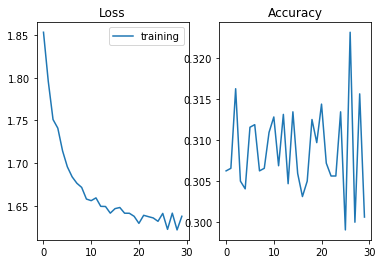

In [16]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.title('Accuracy')